In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

from pyproj import CRS, Transformer

In [2]:
%%time
df = gpd.read_file("data/venice/gis_osm_buildings_a_free_1.shx")
p_df = df.to_crs(epsg=3395)

CPU times: user 2min 32s, sys: 4.57 s, total: 2min 37s
Wall time: 2min 37s


In [3]:
%%time
p_df.sindex

CPU times: user 5min 53s, sys: 1.74 s, total: 5min 55s
Wall time: 5min 57s


In [88]:
tx = Transformer.from_crs('EPSG:4326', 'EPSG:3395', always_xy=True)

In [216]:
bbox = w,s,e,n = 12.3169, 45.4227, 12.3402, 45.4502
p_w, p_s = tx.transform(w, s)
p_e, p_n = tx.transform(e, n)
p_bbox = p_w, p_s, p_e, p_n
assert p_w <= p_e
assert p_s <= p_n

In [213]:
(p_n-p_s)/2

2174.1209488334134

In [95]:
possible_matches = list(p_df.sindex.intersection(p_bbox))
p_sub_df = p_df.iloc[possible_matches]

/home/rohit/.local/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [208]:
from PIL import Image, ImageFont
from PIL.ImageDraw import Draw
from io import BytesIO
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import transform

V_RES = 6144*2

MAIN_OFFSET = (1650/6144)*V_RES
SUBTITLE1_OFFSET = (1500/6144)*V_RES
SUBTITLE2_OFFSET = (1450/6144)*V_RES
TITLE_FONT = ImageFont.truetype("fonts/FiraCode.ttf", size=int((128/6144)*V_RES))
SUBTITLE_FONT = ImageFont.truetype("fonts/FiraCode.ttf", size=int((48/6144)*V_RES))


def rasterize_geometry(geometry, bbox, res=V_RES):
    """
    Given a geometry, bbox, and resolution rasterize the geometry into a numpy array.
    Both geometry and bbox are expected to be in EPSG:3857, but as long as they are in the same CRS the results should be similar.
    The resolution is either a tuple (width, height) to represent a rectangle or a single value res to represent a square.
    """
    w, s, e, n = bbox
    assert w <= e
    assert s <= n
    if type(res) == int:
        sf = (e-w)/(n-s)
        res = int(sf*res), res
    x_res, y_res = res

    def imgspace_transform(xs, ys):
        """
        Given a set of x and y coordinates, convert them to pixels within the current image.
        """
        nonlocal w, s, e, n, x_res, y_res
        xs = np.array(xs)
        ys = np.array(ys)
        xs -= w
        ys -= s
        xs /= e - w
        ys /= n - s
        xs *= x_res
        ys *= y_res
        ys = y_res-ys
        return xs.astype(np.int64), ys.astype(np.int64)

    st, *_ = geometry
    img_geometry = [transform(imgspace_transform, shape) for shape in geometry]
    img_geometry = [list(poly) if type(poly) == MultiPolygon else poly for poly in img_geometry]
    tmp_img_geometry = []
    for poly in img_geometry:
        if type(poly) == list:
            tmp_img_geometry += poly
        else:
            tmp_img_geometry += [poly]
    img_geometry = tmp_img_geometry

    img = Image.new("L", (x_res, y_res))
    draw = Draw(img)
    for polygon in img_geometry:
        if type(polygon) != Polygon:
            print(f"Skipping non-polygon {type(polygon)}!")
            continue
        draw.polygon(list(polygon.exterior.coords), fill=1)
        for interior_hole in polygon.interiors:
            draw.polygon(list(interior_hole.coords), fill=0)

    return img, draw

def dms(w, s, e, n):
    cx = (w+e)/2
    cy = (s+n)/2
    degx, degy = int(cx), int(cy)
    cx -= degx
    cy -= degy
    minx, miny = int(60*cx), int(60*cy)
    cx -= minx/60
    cy -= miny/60
    secx, secy = int(60*cx), int(60*cy)
    ordx = "E" if cx >= 0 else "W"
    ordy = "N" if cx >= 0 else "S"    
    return f"{degy}° {miny}' {secy}\" {ordy}, {degx}° {minx}' {secx}\" {ordx}"

In [209]:
img, draw = rasterize_geometry(p_sub_df.geometry, p_bbox)
h, w = np.array(img).shape
draw.text((150, h-MAIN_OFFSET), "V E N I C E", fill=1, font=TITLE_FONT)
draw.text((150, h-SUBTITLE1_OFFSET), dms(*bbox), fill=1, font=SUBTITLE_FONT)
#draw.text((150, h-SUBTITLE2_OFFSET), "M E R C A T O R    3 3 9 5", fill=1, font=SUBTITLE_FONT)
img = np.array(img)

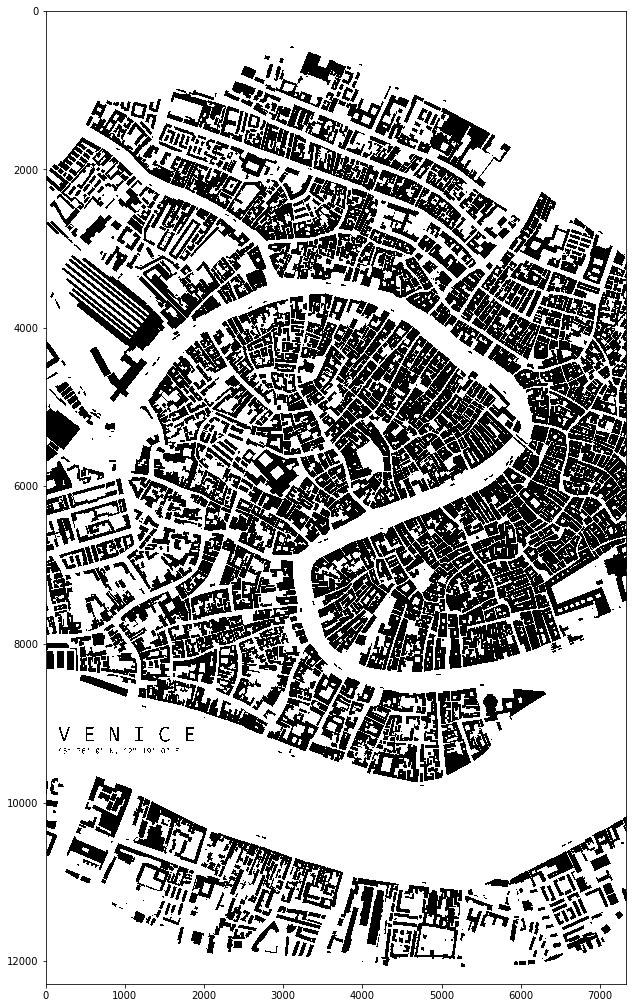

In [210]:
plt.figure(figsize=(30, 30*w/h))
plt.imshow(img, cmap='binary')
plt.show()
plt.imsave("map.png", img, cmap='binary')